In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
import scipy.stats as scs
import matplotlib.pyplot as plt
import pmdarima as pm
import quandl
from statsmodels.tsa.seasonal import seasonal_decompose
from fbprophet import Prophet

import matplotlib.pyplot as plt
import warnings
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100
warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_style("whitegrid")

# Decomposing time series

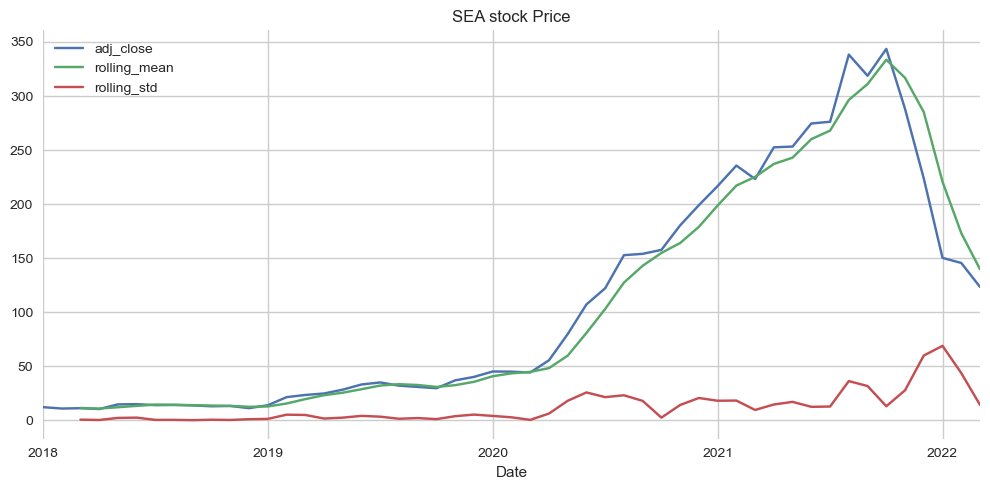

In [23]:
# Download the prices of SEA's stock for years 2018-2022 and resample to monthly values
df = yf.download('SE',
                 start='2018-01-01',
                 end='2022-03-31',
                 adjusted=True,
                 progress=False)

df = df.resample('M').last().rename(columns={'Adj Close': 'adj_close'}).adj_close 
df = pd.DataFrame(df)

# Add rolling mean and standard deviation
WINDOW_SIZE = 3
df['rolling_mean'] = df.adj_close.rolling(window=WINDOW_SIZE).mean()
df['rolling_std'] = df.adj_close.rolling(window=WINDOW_SIZE).std()
df.plot(title='SEA stock Price')

plt.tight_layout()
plt.show()


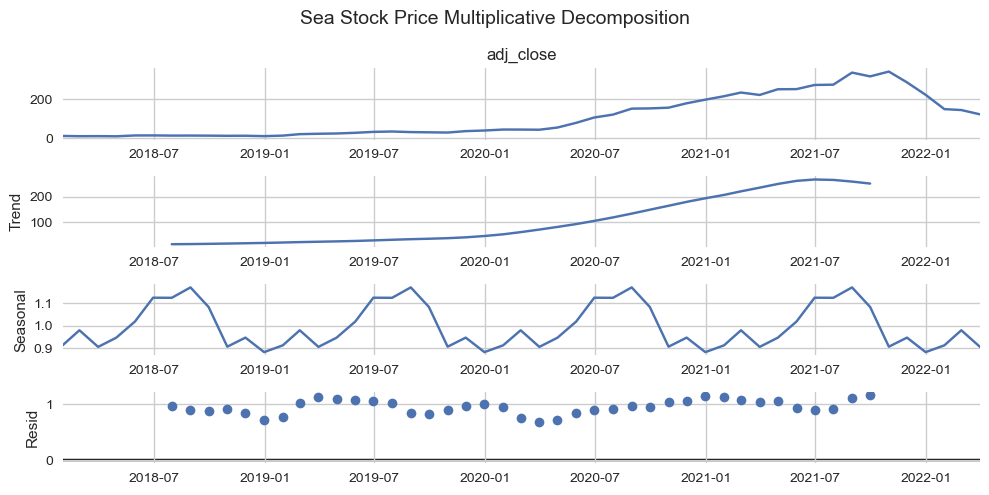

In [27]:
# Carry out seasonal decomposition using the multiplicative model
decomposition_results = seasonal_decompose(df.adj_close, model='multiplicative')
decomposition_results.plot().suptitle('Sea Stock Price Multiplicative Decomposition', fontsize=14)

plt.tight_layout()
plt.show()

## Testing for stationary in time series

In [4]:
# Define a function for running the ADF (Augmented Dickey-Fuller) test:
def adf_test(x):
    '''
    Function for performing the Augmented Dickey-Fuller test for stationarity
    
    Null Hypothesis: time series is not stationary
    Alternate Hypothesis: time series is stationary

    Parameters
    ----------
    x : pd.Series / np.array
        The time series to be checked for stationarity
    
    Returns
    -------
    results: pd.DataFrame
        A DataFrame with the ADF test's results
    '''
    
    indices = ['Test Statistic', 'p-value',
               '# of Lags Used', '# of Observations Used']
    
    adf_test = adfuller(x, autolag='AIC')
    results = pd.Series(adf_test[0:4], index=indices)
    
    for key, value in adf_test[4].items():
        results[f'Critical Value ({key})'] = value

    return results

adf_test(df.adj_close)


Test Statistic            -1.868146
p-value                    0.347191
# of Lags Used             6.000000
# of Observations Used    44.000000
Critical Value (1%)       -3.588573
Critical Value (5%)       -2.929886
Critical Value (10%)      -2.603185
dtype: float64

In [5]:
# Define a function for running the KPSS test:
def kpss_test(x, h0_type='c'):
    '''
    Function for performing the Kwiatkowski-Phillips-Schmidt-Shin test for stationarity

    Null Hypothesis: time series is stationary
    Alternate Hypothesis: time series is not stationary

    Parameters
    ----------
    x: pd.Series / np.array
        The time series to be checked for stationarity
    h0_type: str{'c', 'ct'}
        Indicates the null hypothesis of the KPSS test:
            * 'c': The data is stationary around a constant(default)
            * 'ct': The data is stationary around a trend
    
    Returns
    -------
    results: pd.DataFrame
        A DataFrame with the KPSS test's results
    '''
    
    indices = ['Test Statistic', 'p-value', '# of Lags']

    kpss_test = kpss(x, regression=h0_type)
    results = pd.Series(kpss_test[0:3], index=indices)
    
    for key, value in kpss_test[3].items():
        results[f'Critical Value ({key})'] = value

    return results

kpss_test(df.adj_close)    

Test Statistic            0.446497
p-value                   0.057114
# of Lags                11.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

# Modeling with ARIMA class models

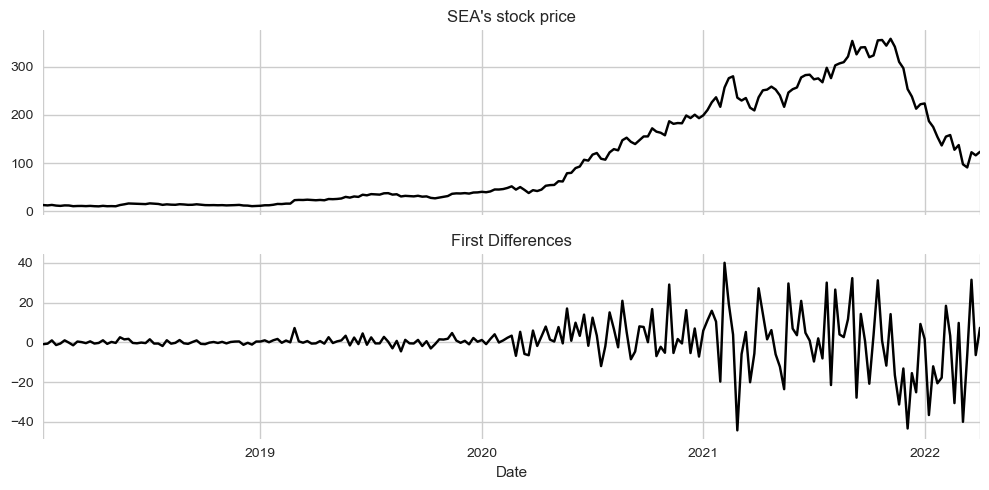

In [11]:
# Download SEA's stock prices and resample to weekly frequency
df = yf.download('SE',
                 start='2018-01-01',
                 end='2022-03-31',
                 adjusted=True,
                 progress=False)

se = df.resample('W') \
         .last() \
         .rename(columns={'Adj Close': 'adj_close'}) \
         .adj_close 

# Apply the first differences to the price series and plot them together
se_diff = se.diff().dropna()

fig, ax = plt.subplots(2, sharex=True)
se.plot(title = "SEA's stock price", ax=ax[0], color='black')
se_diff.plot(ax=ax[1], title='First Differences', color='black')

plt.tight_layout()
plt.show()

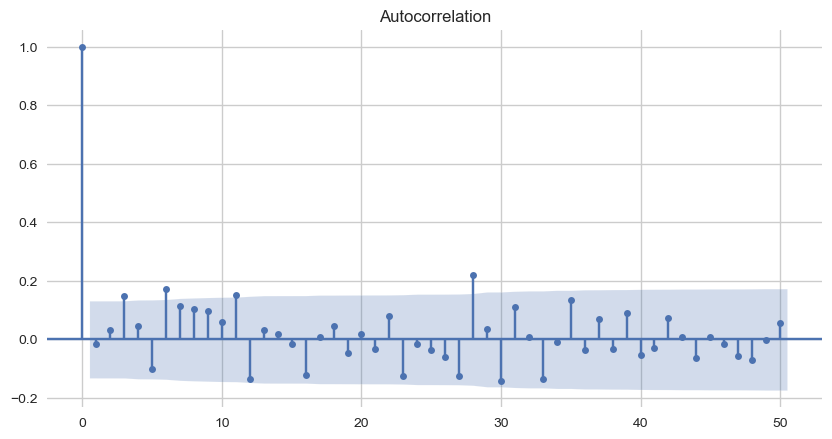

<Figure size 1000x500 with 0 Axes>

In [12]:
# Test the differenced series for stationarity
def test_autocorrelation(df):
    N_LAGS = 50
    SIGNIFICANCE_LEVEL = 0.05
    acf = smt.graphics.plot_acf(df, lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL)

    plt.show()

fig = test_autocorrelation(se_diff)

plt.tight_layout()
plt.show()

In [13]:
# Based on the results of the tests, specify the ARIMA model and fit it to the data
arima = ARIMA(se, order=(2, 1, 1)).fit(disp=0)
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.adj_close   No. Observations:                  221
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -850.994
Method:                       css-mle   S.D. of innovations             11.376
Date:                Sat, 02 Apr 2022   AIC                           1711.987
Time:                        13:10:47   BIC                           1728.978
Sample:                    01-14-2018   HQIC                          1718.848
                         - 04-03-2022                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3806      1.281      0.297      0.766      -2.131       2.892
ar.L1.D.adj_close     0.8049      0.112      7.202      0.000       0.586       1.024
ar.L2.D.adj_close     0.1016      0.069      1.465      0.143      -0.034       0.238
ma.L1.D.adj_close    -0.8414      0.093     -9.062      0.000      -1.023      -0.659
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0918           +0.0000j            1.0918            0.0000
AR.2           -9.0112           +0.0000j            9.0112            0.5000
MA.1            1.1885           +0.0000j            1.1885            0.0000
-----------------------------------------------------------------------------
"""

/opt/miniconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


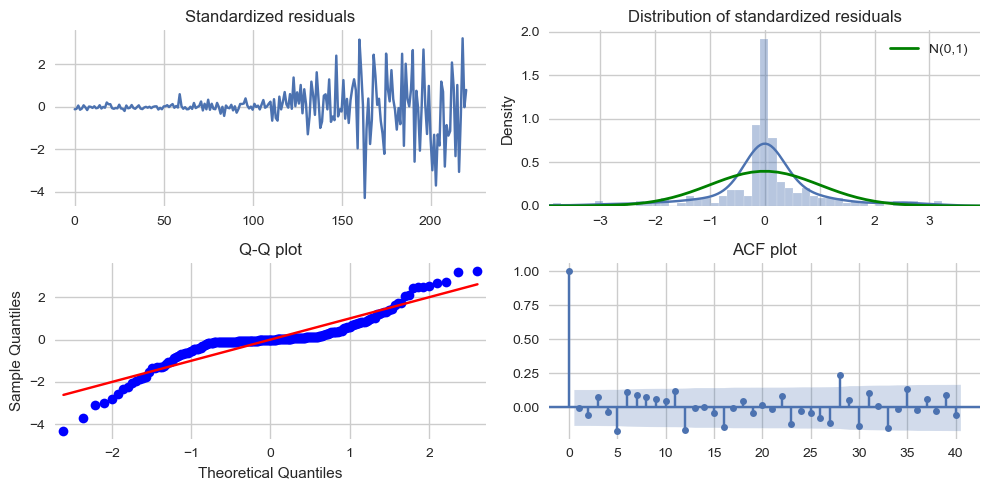

In [24]:
# Prepare a function for diagnosing the fit of the model based on its residuals
def arima_diagnostics(resids, n_lags=40):
    '''
    Function for diagnosing the fit of an ARIMA model by investigating the residuals.
    
    Parameters
    ----------
    resids : np.array
        An array containing the residuals of a fitted model
    n_lags : int
        Number of lags for autocorrelation plot
        
    Returns
    -------
    fig : matplotlib.figure.Figure
        Created figure
    '''
     
    # create placeholder subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

    r = resids
    resids = (r - np.nanmean(r)) / np.nanstd(r)
    resids_nonmissing = resids[~(np.isnan(resids))]
    
    # residuals over time
    sns.lineplot(x=np.arange(len(resids)), y=resids, ax=ax1)
    ax1.set_title('Standardized residuals')

    # distribution of residuals
    x_lim = (-1.96 * 2, 1.96 * 2)
    r_range = np.linspace(x_lim[0], x_lim[1])
    norm_pdf = scs.norm.pdf(r_range)
    
    sns.distplot(resids_nonmissing, hist=True, kde=True, 
                 norm_hist=True, ax=ax2)
    ax2.plot(r_range, norm_pdf, 'g', lw=2, label='N(0,1)')
    ax2.set_title('Distribution of standardized residuals')
    ax2.set_xlim(x_lim)
    ax2.legend()
        
    # Q-Q plot
    qq = sm.qqplot(resids_nonmissing, line='s', ax=ax3)
    ax3.set_title('Q-Q plot')

    # ACF plot
    plot_acf(resids, ax=ax4, lags=n_lags, alpha=0.05)
    ax4.set_title('ACF plot')

    return fig

# Test the residuals of the fitted ARIMA model:
arima_diagnostics(arima.resid, 40)

plt.tight_layout()
#plt.savefig('images/ch3_im21.png')
plt.show()

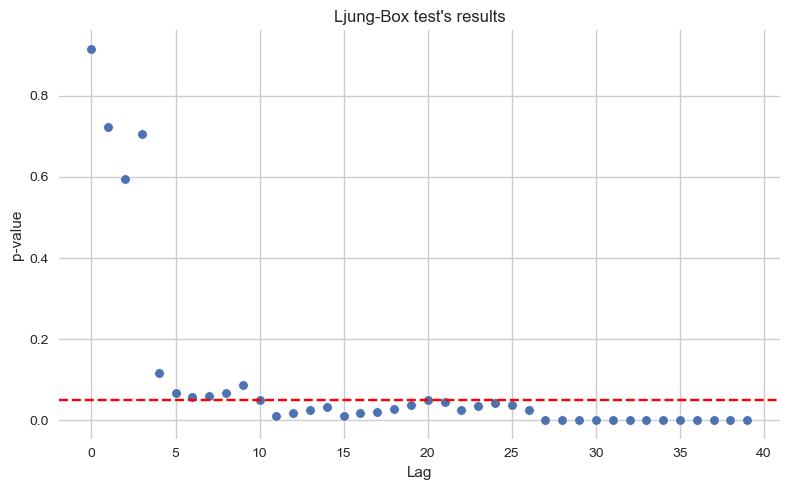

In [16]:
# Apply the Ljung-Box's test for no autocorrelation in the residuals and plot the results
ljung_box_results = acorr_ljungbox(arima.resid)

fig, ax = plt.subplots(1, figsize=[8, 5])
sns.scatterplot(x=range(len(ljung_box_results[1])), 
                y=ljung_box_results[1], 
                ax=ax)
ax.axhline(0.05, ls='--', c='r')
ax.set(title="Ljung-Box test's results",
       xlabel='Lag',
       ylabel='p-value')

plt.tight_layout()
plt.show()

## Using Auto Arima

In [25]:
# We run `auto_arima` with the majority of settings set to default values. We only exclude potential seasonality.
auto_arima = pm.auto_arima(se, error_action='ignore', suppress_warnings=True, seasonal=False)

# In the next step we try to tune the search of the optimal parameters:
auto_arima = pm.auto_arima(se, error_action='ignore', suppress_warnings=True, seasonal=False,
                           stepwise=False, approximation=False, n_jobs=-1)

auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  222
Model:               SARIMAX(3, 1, 2)   Log Likelihood                -846.226
Date:                Sat, 02 Apr 2022   AIC                           1706.452
Time:                        13:16:23   BIC                           1730.239
Sample:                             0   HQIC                          1716.057
                                - 222                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.9901      1.737      0.570      0.569      -2.415       4.395
ar.L1         -0.2906      0.054     -5.415      0.000      -0.396      -0.185
ar.L2         -0.9178      0.034    -26.992      0.000      -0.984      -0.851
ar.L3          0.0790      0.052      1.509      0.131      -0.024       0.182
ma.L1          0.2876      0.022     13.348      0.000       0.245       0.330
ma.L2          0.9446      0.028     33.601      0.000       0.890       1.000
sigma2       122.7659      6.882     17.838      0.000     109.277     136.255
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               195.72
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):             182.40   Skew:                            -0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Forecasting with auto-Arima

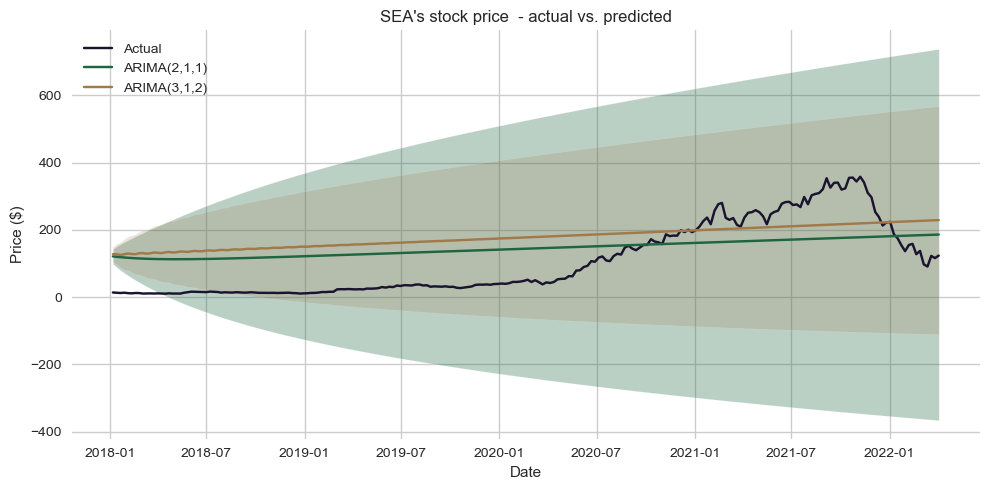

In [26]:
# Obtain forecasts from the first model and store them in a DataFrame:
n_forecasts = len(se)

arima_pred = arima.forecast(n_forecasts)

arima_pred = [pd.DataFrame(arima_pred[0], columns=['prediction']),
              pd.DataFrame(arima_pred[2], columns=['ci_lower', 'ci_upper'])]

arima_pred = pd.concat(arima_pred, axis=1).set_index(se.index)

# Obtain forecasts from the second model and store them in a DataFrame:
auto_arima_pred = auto_arima.predict(n_periods=n_forecasts, return_conf_int=True, alpha=0.05)

auto_arima_pred = [pd.DataFrame(auto_arima_pred[0], columns=['prediction']),
                   pd.DataFrame(auto_arima_pred[1], columns=['ci_lower', 'ci_upper'])]
auto_arima_pred = pd.concat(auto_arima_pred, axis=1).set_index(se.index)

# Obtain forecasts from the second model and store them in a DataFrame:
auto_arima_pred = auto_arima.predict(n_periods=n_forecasts, 
                                     return_conf_int=True, 
                                     alpha=0.05)

auto_arima_pred = [pd.DataFrame(auto_arima_pred[0], columns=['prediction']),
                   pd.DataFrame(auto_arima_pred[1], columns=['ci_lower', 'ci_upper'])]
auto_arima_pred = pd.concat(auto_arima_pred, axis=1).set_index(se.index)

# plot the results
COLORS = [plt.cm.cubehelix(x) for x in [0.1, 0.3, 0.5, 0.7]]

fig, ax = plt.subplots(1)

ax = sns.lineplot(data=se, color=COLORS[0], label='Actual')

ax.plot(arima_pred.prediction, c=COLORS[1], label='ARIMA(2,1,1)')
ax.fill_between(arima_pred.index,arima_pred.ci_lower,arima_pred.ci_upper,alpha=0.3, facecolor=COLORS[1])

ax.plot(auto_arima_pred.prediction, c=COLORS[2], label='ARIMA(3,1,2)')
ax.fill_between(auto_arima_pred.index, auto_arima_pred.ci_lower, auto_arima_pred.ci_upper, alpha=0.2, facecolor=COLORS[2])

ax.set(title="SEA's stock price  - actual vs. predicted", xlabel='Date', ylabel='Price ($)')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()